In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)
print(Measurement)

<class 'sqlalchemy.ext.automap.measurement'>


# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#########################################################################################

# check an instance of the data in measurement
data = session.query(Measurement).first()
data.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11a0e7978>,
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1,
 'prcp': 0.08,
 'station': 'USC00519397'}

In [12]:
# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
#  ('2017-08-23')
year_earlier = dt.date(2017,8,23) - dt.timedelta(days=365)
print(year_earlier)

2016-08-23


In [13]:
# Perform a query to retrieve the date and precipitation scores
# sort the query by date (couldn't get the sorted dataframe to plot properly)
precip_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_earlier).order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_data)
p_index_df = precip_df.set_index('date',drop=True)
# show sorted dataframe
p_index_df.head()



,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


In [14]:
# clean out the NaN's
clean_prcp_df = p_index_df.dropna()
clean_prcp_df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,0.02
2016-08-23,1.79


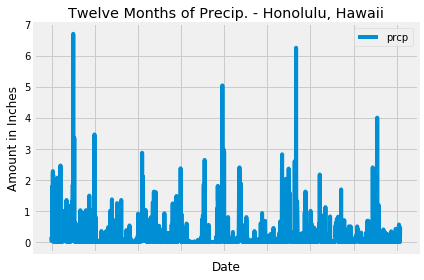

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
clean_prcp_df.plot()
plt.title("Twelve Months of Precip. - Honolulu, Hawaii")
plt.xlabel("Date")
plt.ylabel("Amount in Inches")
plt.tight_layout()
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
# use transpose() to make it read easier (my opinion)
summary_stats = clean_prcp_df.describe().transpose()
summary_stats

,count,mean,std,min,25%,50%,75%,max
prcp,2021.0,0.177279,0.46119,0.0,0.0,0.02,0.13,6.7


![describe](Images/describe.png)

In [17]:
# check an instance of the data in Station
s_data = session.query(Station).first()
s_data.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x11a503710>,
 'id': 1,
 'longitude': -157.8168,
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0,
 'name': 'WAIKIKI 717.2, HI US'}

In [18]:
# Design a query to show how many stations are available in this dataset?
total_stations = session.query(Station).count()
total_stations

9

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
station_activity = session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).order_by(func.count(Measurement.tobs).desc()).all()

for station, count in station_activity:
    print(station, "had", count, "readings")


USC00519281 had 2772 readings
USC00519397 had 2724 readings
USC00513117 had 2709 readings
USC00519523 had 2669 readings
USC00516128 had 2612 readings
USC00514830 had 2202 readings
USC00511918 had 1979 readings
USC00517948 had 1372 readings
USC00518838 had 511 readings


In [20]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
# station_activity
most_active_station = session.query(Measurement.station, Measurement.tobs).\
    filter(Measurement.station=="USC00519281").all()
most_active_sorted = sorted(most_active_station, reverse=True)

highest_temp = most_active_sorted[0][1]

lowest_temp = most_active_sorted[len(most_active_sorted)-1][1]

average_temp = round(sum(x[1] for x in most_active_sorted)/len(most_active_sorted), 2)

print("Highest temp recorderd at station", station, "was", highest_temp)
print("Lowest temp recorderd at station", station, "was", lowest_temp)
print("Average temp recorderd at, station", station, "was", average_temp)

Highest temp recorderd at station USC00518838 was 85.0
Lowest temp recorderd at station USC00518838 was 54.0
Average temp recorderd at, station USC00518838 was 71.66


In [21]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# use previously created dates for query
temp_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station=="USC00519281").\
    filter(Measurement.date >= year_earlier).order_by(Measurement.date).all()
temp_data

# Save the query results as a Pandas DataFrame
temp_data_df = pd.DataFrame(temp_data)
temp_data_df.head(5)



,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0


Text(0.5,1,"Last 12 Months' Temps @ USC00519281")

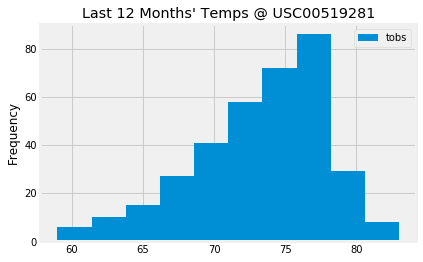

In [22]:
# Use Pandas Plotting with Matplotlib to plot the data
temp_data_df.plot('date', 'tobs', kind='hist')
plt.title("Last 12 Months' Temps @ USC00519281")


![precipitation](Images/station-histogram.png)

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [24]:
# My trip to Honolulu, Hawaii will be from July 1st through July 7th.

# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_temps = calc_temps('2017-07-01', '2017-07-07')
trip_temps

[(74.0, 78.175, 87.0)]

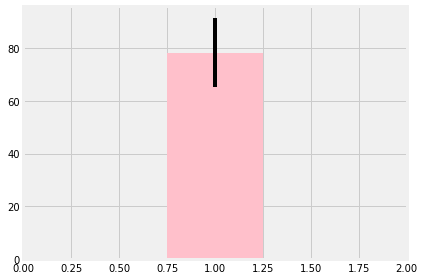

In [45]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

# See https://matplotlib.org/gallery/statistics/barchart_demo.html 

x = 1
avg_temp = trip_temps[0][1]
temp_range = trip_temps[0][2] - trip_temps[0][0]
plt.bar(x, avg_temp, width=.5, color='pink', yerr=temp_range)
plt.xlim(0,2)
plt.tight_layout()
plt.show()

In [ ]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
